In [7]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))

In [21]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import scipy
from tqdm.auto import tqdm
import helper_libraries.results_tools as results_tools

sns.set_context("paper", font_scale=1.7)
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

# Load data

## Market returns, risk-free, and spread

In [9]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

## ENet forecast results

In [10]:
## Raw results across grid
with open("../../results/L1vsL2/Enet_results", "rb") as fp:
    enet_results = pickle.load(fp)

# Predictions
enet_results_pred = enet_results[0]

# Hyperparams
enet_results_hyperparams = enet_results[1]

In [242]:
## Main results
# Raw results
with open("../../results/main/Enet_log.pkl", "rb") as fp:
    enet_results_main = pickle.load(fp)

## Reformat

In [12]:
## Reformat all above results in the same way as other trading results

# Get column names
model_list = ['Enet__' + '~~'.join(x) for x in enet_results_hyperparams]

# Get values
forecast_oss_df = pd.concat(enet_results_pred, axis=1)
forecast_oss_df.columns = ['oss_' + x for x in model_list]


# Update in-sample results
# **Note that insample is set to same as the oss
forecast_ins_df = forecast_oss_df.copy()
forecast_ins_df.columns = ['ins_' + x for x in model_list]

# Main

## Get trading results

In [13]:
## Params

# Year to start trading
start_year = "2004"

# Define strategies and models
strategies_list = [
    "MS Strategy 1",
]

# Metrics and their names
metrics_list = ["Return", "ReturnAdj", "Sharpe", "SharpeAdj", "Trades", "rvol"]
metrics_names_list = [
    "Return",
    "Adjusted Return",
    "Sharpe",
    "Adjusted Sharpe",
    "Trades",
    "Realized Volatility",
]

In [61]:
## Get trading results

# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:]
forecast_ins_filter_df = forecast_ins_df.loc[: str(int(start_year) - 1)].copy()
fret_filter_df = fret_df.loc[start_year:]
hrf_filter_df = hrf_df.loc[start_year:]

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=True,
    display_progress=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

## Reformat trading results

In [62]:
# Get L1 and L2 penalty info
oss_results_all_df["hyperparam_alpha"] = oss_results_all_df["Name"].apply(
    lambda x: x.split("__")[-1].split("~~")[0]
).astype(float)
oss_results_all_df["hyperparam_l1ratio"] = oss_results_all_df["Name"].apply(
    lambda x: x.split("__")[-1].split("~~")[1]
).astype(float)
oss_results_all_df["L1"] = oss_results_all_df["hyperparam_alpha"] * (
    oss_results_all_df["hyperparam_l1ratio"]
)
oss_results_all_df["L2"] = oss_results_all_df["hyperparam_alpha"] * (
    1 - oss_results_all_df["hyperparam_l1ratio"]
)

In [251]:
enet_results_main_fmt_df = enet_results_main.iloc[3:].reset_index()

In [260]:
enet_results_main_fmt_df["hyperparameters"].apply(lambda x: x[0]["l1_ratio"]).astype(float)

0    0.891111
1    0.020000
2    1.000000
3    0.891111
4    0.020000
5    0.346667
6    0.020000
7    0.455556
8    0.020000
Name: hyperparameters, dtype: float64

In [263]:
## For main results

enet_results_main_fmt_df = enet_results_main.iloc[3:].reset_index()
enet_results_main_fmt_df["hyperparam_alpha"] = (
    enet_results_main_fmt_df["hyperparameters"].apply(lambda x: x[0]["lambda"]).astype(float)
)
enet_results_main_fmt_df["hyperparam_l1ratio"] = (
    enet_results_main_fmt_df["hyperparameters"].apply(lambda x: x[0]["l1_ratio"]).astype(float)
)
enet_results_main_fmt_df["L1"] = enet_results_main_fmt_df["hyperparam_alpha"] * (
    enet_results_main_fmt_df["hyperparam_l1ratio"]
)
enet_results_main_fmt_df["L2"] = enet_results_main_fmt_df["hyperparam_alpha"] * (
    1 - enet_results_main_fmt_df["hyperparam_l1ratio"]
)

In [64]:
# Add R2
resid = forecast_oss_filter_df.subtract(fret_df['ff__mkt'], axis=0).dropna()
r2 = 1- resid.pipe(np.square).sum()/fret_df.loc[resid.index].pipe(np.square).sum().iloc[0]

oss_results_all_df['R2'] = r2.loc[oss_results_all_df['Name (col)']].values

## Plot

<AxesSubplot:xlabel='L1', ylabel='L2'>

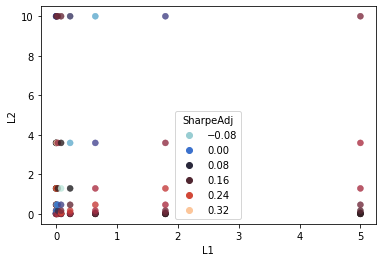

In [16]:
sns.scatterplot(
    x="L1", y="L2", hue="SharpeAdj", palette="icefire", edgecolor=None, alpha = 0.8, data=oss_results_all_df
)
# plt.xlim(0,0.5)

### Heatmap

In [298]:
def plot_sharpe_heatmap(fig, ax, plot_data, vmin=-1, vmax=1):
    
    # Params
    metric = "Sharpe"

    # Data for plotting
    plot_df = plot_data.copy()
    plot_df = plot_df#.query('L1 < 0.3 & L2 < 1.5')

    x = np.log(plot_df["L1"])
    y = np.log(plot_df["L2"])
    z = plot_df[metric]

    # x = np.random.uniform(-1,1,5000)
    # y = np.random.uniform(-1,1,5000)
    # z = x+y + (y > 0.8).astype(int)/4

    # Color bar information
    vcenter = 0
    # vmin, vmax = z.min(), z.max()
    normalize = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
    # normalize = mcolors.TwoSlopeNorm(vmin=-0.01, vcenter=-0.005, vmax=0)
    colormap = cm.RdBu

    # Create grid
    xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate missing data
    rbf = scipy.interpolate.Rbf(x, y, z, function="linear")
    zi = rbf(xi, yi)

    # Heat map
    ax.imshow(
        zi,
        aspect='auto',
        interpolation="bilinear",
        cmap=colormap,
        norm=normalize,
        origin='lower',
        extent=[x.min(), x.max(), y.min(), y.max()],
    )

    # Other settings
    ax.grid(False)
    ax.set_title('Adjusted Sharpe for ENet + Std Strategy 1')
    fig.patch.set_alpha(0)
    ax.set_xlabel('log(L1 Penalty)')
    ax.set_ylabel('log(L2 Penalty)')
    plt.tight_layout()
    
    return fig, ax

In [299]:
# Compute Sharpe for each OOS period
mu = oss_returns_all_df.groupby(pd.Grouper(freq = '2y')).sum() / 2
vol = np.sqrt(oss_returns_all_df.pipe(np.square).groupby(pd.Grouper(freq = '2y')).sum() / 2)
sharpe = (mu/vol).sort_index()

  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_27372/3936025999.py:48: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(scalarmappaple)


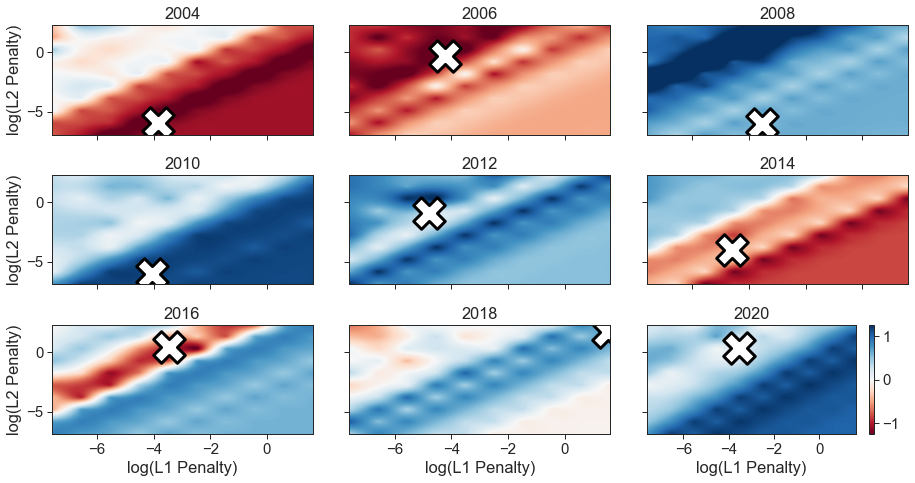

In [305]:
# Figure
fig, axs = plt.subplots(figsize=(13, 7), ncols=3, nrows=3, sharex=True, sharey=True)

# For each oos period
for i in tqdm(range(9)):

    # Get axis
    ax = axs.reshape(-1)[i]

    # Get grid for this year
    oss_results_all_year_df = oss_results_all_df.set_index("Name").copy()
    oss_results_all_year_df["Sharpe"] = sharpe.iloc[
        i,
    ].droplevel(1)

    # Heatmap of grid
    plot_sharpe_heatmap(fig, ax, oss_results_all_year_df, vmin=-1.25, vmax =1.25)
    period_name = sharpe.index[i].strftime("%Y")
    ax.set_title(period_name)

    # Get our selected hyperparams from main results
    main_select_l1 = enet_results_main_fmt_df.iloc[i]["L1"]
    main_select_l2 = np.max([enet_results_main_fmt_df.iloc[i]["L2"], np.exp(-6)])
    ax.scatter(
        [np.log(main_select_l1)],
        [np.log(main_select_l2)],
        marker="X",
        s=1000,
        edgecolor="k",
        lw=3,
        color="white",
    )

    # Clean up labels
    if i < 6:
        ax.set_xlabel(None)
    if (i) % 3 != 0:
        ax.set_ylabel(None)

# Color bar information
vcenter = 0
vmin, vmax = z.min(), z.max()
normalize = mcolors.TwoSlopeNorm(vcenter=0, vmin=-1.25, vmax=1.25)

# Color bar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(z)
fig.colorbar(scalarmappaple)
plt.savefig('../../docs/exhibits/figures/hyperparameters_penalty_heatmap_over_time.pdf')

# Scratch

## Pointplot

/tmp/ipykernel_27372/2308424077.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(scalarmappaple)


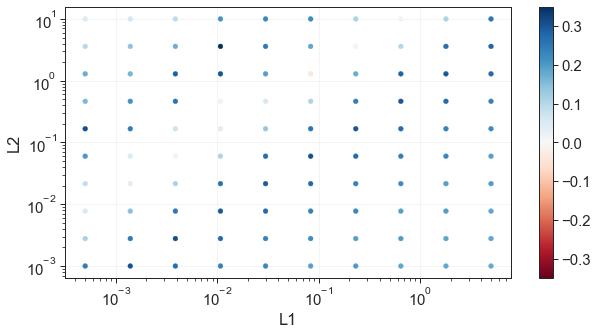

In [103]:
# Params
metric = "Return"

fig, ax = plt.subplots(figsize=(10, 5))

# Points
sns.scatterplot(
    x=plot_df['L1'],
    y=plot_df['L2'],
    c=z,
    # hue=metric,
    norm=normalize,
    cmap=colormap,
    edgecolor=None,
    ax=ax,
)

# Color bar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(z)
fig.colorbar(scalarmappaple)

plt.yscale('log')
plt.xscale('log')
# plt.xlim(-0.1, 0.5)
# plt.ylim(4, 0)

## Grid generation

In [115]:
N = 10
l1_range = np.power(N, np.linspace(-3, 1, 10)) *0.5
l2_range = np.power(N, np.linspace(-3, 1, 10)) # doubling the l2 here since sklearn divides by two
alpha_range = np.zeros((N, N))
ratio_range = np.zeros((N, N))
for l_1 in range(len(l1_range)):
  for l_2 in range(len(l2_range)):
    alpha_range[l_1,l_2] = l1_range[l_1] + l2_range[l_2]
    ratio_range[l_1,l_2] = l1_range[l_1] / (l1_range[l_1] + l2_range[l_2])
grid = [alpha_range.flatten(), ratio_range.flatten()]

In [116]:
# Some fake data
fake_sharpe_df = pd.DataFrame(
    [alpha_range.flatten(), ratio_range.flatten(), np.random.rand(N ** 2)],
    index=["hyperparam_alpha", "hyperparam_l1ratio", "Sharpe"],
).T
# fake_sharpe_df = oss_results_all_df

fake_sharpe_df['L1'] = fake_sharpe_df["hyperparam_alpha"] * (
    fake_sharpe_df["hyperparam_l1ratio"]
)
fake_sharpe_df["L2"] = fake_sharpe_df["hyperparam_alpha"] * (
    1 - fake_sharpe_df["hyperparam_l1ratio"]
) / 2
fake_sharpe_df.sample(5)

,hyperparam_alpha,hyperparam_l1ratio,Sharpe,L1,L2
75,0.812585,0.794717,0.653954,0.645775,0.083405
7,1.292050,0.000387,0.187730,0.000500,0.645775
91,5.002783,0.999444,0.017703,5.000000,0.001391
55,0.250215,0.333333,0.362293,0.083405,0.083405
25,0.170681,0.022682,0.036683,0.003871,0.083405


<AxesSubplot:xlabel='hyperparam_alpha', ylabel='hyperparam_l1ratio'>

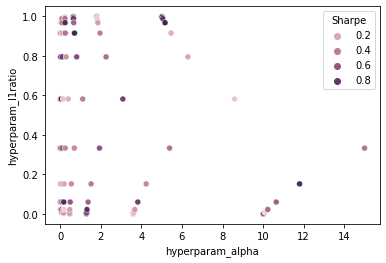

In [117]:
sns.scatterplot(x = 'hyperparam_alpha', y= 'hyperparam_l1ratio', hue = 'Sharpe', data= fake_sharpe_df)

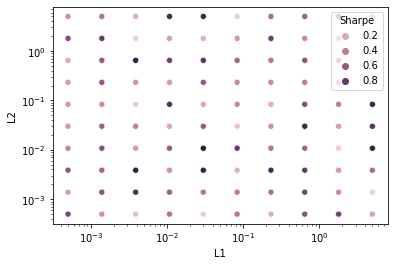

In [118]:
sns.scatterplot(x = 'L1', y= 'L2', hue = 'Sharpe', data= fake_sharpe_df)
plt.yscale('log')
plt.xscale('log')